In [25]:
# https://www.kaggle.com/pablocastilla/predict-if-a-shot-is-made

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import math

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [26]:
cwd = os.getcwd()

cwd = cwd + str('\datasets\shot_logs.csv')

data = pd.read_csv(cwd)

In [27]:
data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [28]:
data.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [29]:
#only positives TOUCH_TIME
data=data[data['TOUCH_TIME']>=0]

#shot_dist too far
data=data[data['SHOT_DIST']<40]

#REMOVE SHOT_CLOCK NAN
nan=float('nan')
data=data[~np.isnan(data['SHOT_CLOCK'])]

#REMOVE FGM NAN
nan=float('nan')
data=data[~np.isnan(data['FGM'])]

#CLose def dist
data=data[data['CLOSE_DEF_DIST']<30]

In [30]:
y = data['FGM']
#Only use numerical data. Remove points as it is totally correlated with target
x = data[['SHOT_DIST','player_id','TOUCH_TIME','FINAL_MARGIN','PERIOD','SHOT_CLOCK','DRIBBLES','CLOSE_DEF_DIST']]

In [31]:
model = XGBClassifier()
model.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

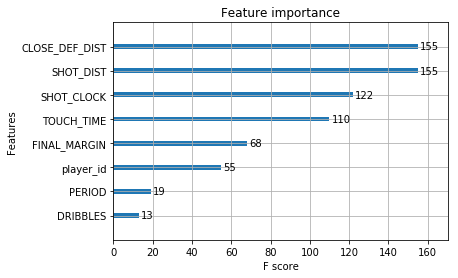

In [32]:
plot_importance(model, importance_type = 'weight')
pyplot.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split( x[['SHOT_DIST','TOUCH_TIME','CLOSE_DEF_DIST','SHOT_CLOCK', 'player_id']], y, test_size=0.50, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split( X_test, y_test, test_size=0.50, random_state=42)
    

In [35]:
parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[1,3,5,10],
    'max_depth':[3,4, 5, 6, 7, 8, 9]
}

xgb_model = XGBClassifier()

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, scoring='precision')
gsearch1.fit(X_train[['SHOT_DIST','TOUCH_TIME','CLOSE_DEF_DIST','SHOT_CLOCK', 'player_id']],y_train)

print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)   

C:\Users\caleb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best params
{'learning_rate': 1e-05, 'max_depth': 3, 'min_child_weight': 0.0001, 'n_estimators': 1}
best score
0.6807194689514227


In [36]:
xgb_model = XGBClassifier(min_child_weight=0.0001,learning_rate=1e-05,
                              n_estimators=1,max_depth=3).fit(X_train,y_train)
predictions = xgb_model.predict(X_test)
actuals = y_test        
precision=precision_score(actuals, predictions)
print(precision)

0.679740913997841
